Dataset: http://nlp.uit.edu.vn/datasets/

Classify 7 states of emotions in terms of enjoyment, disgust, sadness, anger, surprise, fear and others from text using PhoBert, a state of the art pre-trained BERT for the Vietnamese language

From UIT with ♥

### About data:

Emotion recognition is a higher approach or special case of sentiment analysis. In this task, the result is not produced in terms of either polarity: positive or negative or in the form of rating (from 1 to 5) but of a more detailed level of sentiment analysis in which the result are depicted in more expressions like sadness, enjoyment, anger, disgust, fear and surprise. Emotion recognition plays a critical role in measuring brand value of a product by recognizing specific emotions of customers’ comments. In this study, we have achieved two targets. First and foremost, we built a standard Vietnamese Social Media Emotion Corpus (UIT-VSMEC) with about 6,927 human-annotated sentences with six emotion labels, contributing to emotion recognition research in Vietnamese which is a low-resource language in Natural Language Processing (NLP). Secondly, we assessed and measured machine learning and deep neural network models on our UIT-VSMEC. As a result, Convolutional Neural Network (CNN) model achieved the highest performance with 57.61% of F1-score.

### Set Up

In [1]:
# For read excel format form pandas
!pip install openpyxl
# For Vietnamese word_segment
!pip install pyvi


     |████████████████████████████████| 251 kB 9.0 MB/s            
     |████████████████████████████████| 8.5 MB 8.1 MB/s            
     |████████████████████████████████| 1.1 MB 61.2 MB/s            


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyvi import ViTokenizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [3]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(42)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 10

### Load Data

In [5]:
from datasets import load_dataset

ds = load_dataset("duwuonline/UIT-VSMEC")

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/463k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/57.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/57.8k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/duwuonline--UIT-VSMEC-5c258cf5c293daa2/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['Emotion', 'Sentence'],
        num_rows: 5548
    })
    test: Dataset({
        features: ['Emotion', 'Sentence'],
        num_rows: 693
    })
    validation: Dataset({
        features: ['Emotion', 'Sentence'],
        num_rows: 686
    })
})

In [7]:
train_df = ds['train'].to_pandas()
valid_df = ds['validation'].to_pandas()
test_df = ds['test'].to_pandas()

# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_, "kfold"] = fold

In [8]:
train_df.sample(5)

,Emotion,Sentence,kfold
599,Sadness,thế là hết những gì đẹp nhất của nước pháp sao...,1.0
5818,Other,may không đi,9.0
5386,Disgust,tao thấy mấy thằng đi sh 10 thằng thì 9 thằng ...,8.0
401,Disgust,chủ tịch rả vờ ngu và cái kết đừng bao rờ khin...,0.0
1268,Sadness,"per như một cú tát vào mặt , đau lòng quá đi",2.0


In [9]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   6234 non-null   object 
 1   Sentence  6234 non-null   object 
 2   kfold     6234 non-null   float64
dtypes: float64(1), object(2)
memory usage: 146.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None)

**=> No Missing Values**

<AxesSubplot:xlabel='Emotion', ylabel='count'>

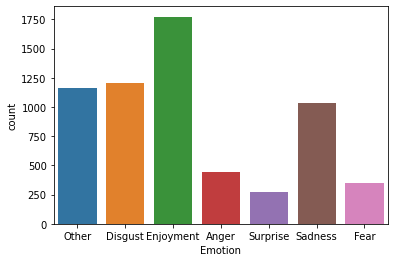

In [10]:
sns.countplot(x='Emotion', data=train_df)

**=> Imbalanced labels! But We still want to classify 7 classes**

### DataLoader

In [11]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

A word segmenter must be applied to produce word-segmented texts before feeding to PhoBERT

In [12]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Enjoyment':
            return 0
        elif text=='Disgust':
            return 1
        elif text=='Sadness':
            return 2
        elif text=='Anger':
            return 3
        elif text=='Surprise':
            return 4
        elif text=='Fear':
            return 5
        else:
            return 6

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        text = ViTokenizer.tokenize(text)
        label = self.labelencoder(row['Emotion'])

        return text, label

**BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.**

Text(0.5, 6.79999999999999, 'Token Count')

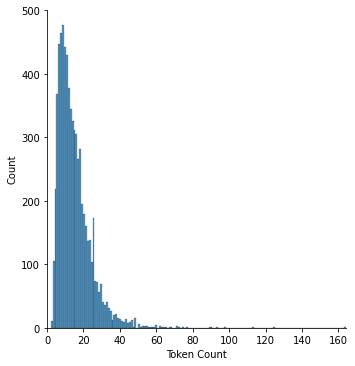

In [13]:
# Distribution of length of Sentence
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

**=> Choose a maximum of length of 50 is safe.**

### Model

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

### Train & Eval Function

In [15]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


### Training with K-Fold

In [16]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [17]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Epoch 1/6
------------------------------
Train Accuracy: 0.38467023172905523 Loss: 1.6411638484041915
Valid Accuracy: 0.5625 Loss: 1.2652431634756236
Epoch 2/6
------------------------------
Train Accuracy: 0.5828877005347594 Loss: 1.2025062502958836
Valid Accuracy: 0.6073717948717948 Loss: 1.0957321371787634
Epoch 3/6
------------------------------
Train Accuracy: 0.6807486631016043 Loss: 0.9504352071006753
Valid Accuracy: 0.6314102564102564 Loss: 1.0604686461962187
Epoch 4/6
------------------------------
Train Accuracy: 0.7338680926916221 Loss: 0.785454822571529
Valid Accuracy: 0.6153846153846154 Loss: 1.1022203121429834
Epoch 5/6
------------------------------
Train Accuracy: 0.7934046345811051 Loss: 0.6546166178337869
Valid Accuracy: 0.6346153846153846 Loss: 1.1424904251709962
Epoch 6/6
------------------------------
Train Accuracy: 0.8270944741532976 Loss: 0.5631803753454121
Valid Accuracy: 0.6394230769230769 Loss: 1.1429845782426686
-----------Fold: 2 ------------------
Epoch 1/

In [18]:
def test_kfold(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [19]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test_kfold(test_loader)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       193
           1       0.61      0.63      0.62       132
           2       0.66      0.66      0.66       116
           3       0.46      0.42      0.44        40
           4       0.67      0.38      0.48        37
           5       0.70      0.65      0.67        46
           6       0.53      0.60      0.56       129

    accuracy                           0.62       693
   macro avg       0.62      0.58      0.59       693
weighted avg       0.63      0.62      0.62       693



### Heatmap between Predict and Ground Truth

<AxesSubplot:>

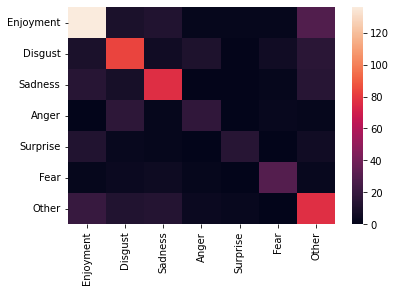

In [20]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

=> Label Fear is the most unrelated to others -> Highest F1-Score

### Visualize Wrong Predicted Label

In [21]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
nhà thì không xa lắm nhưng chưa bao giờ đi vì sợ bị đè bẹp luôn người =)))))
Predicted: (Enjoyment) --vs-- Real label: (Surprise)
--------------------------------------------------
per trình mày vẫn còn thấp chán =))
Predicted: (Other) --vs-- Real label: (Enjoyment)
--------------------------------------------------
ổng quay thiệt mà sao chửi ổng thế . không quay sao máy bạn xem được đó :))
Predicted: (Disgust) --vs-- Real label: (Anger)
--------------------------------------------------
nghe ngọt thế :((
Predicted: (Enjoyment) --vs-- Real label: (Fear)
--------------------------------------------------
sao lại cứ phải thế nhỉ
Predicted: (Enjoyment) --vs-- Real label: (Surprise)
--------------------------------------------------
mệt vãi .. mà cừời cũng vãi ??????
Predicted: (Other) --vs-- Real label: (Disgust)
--------------------------------------------------
hậu duệ mặt trời đấy chứ đùa đâu nhá 😗😗
Predicted: (Anger) --vs-- Real label

### Inference

In [22]:
def infer(text, tokenizer, max_len=120):
    print(f'Text: {text}')
    text = ' '.join(simple_preprocess(text))
    text = ViTokenizer.tokenize(text)
    
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Sentiment: {class_names[y_pred]}')

In [23]:
infer('Cảm ơn bạn đã chạy thử model của mình. Chúc một ngày tốt lành nha!', tokenizer)

Text: Cảm ơn bạn đã chạy thử model của mình. Chúc một ngày tốt lành nha!
Sentiment: Enjoyment


### <center> Thanks for reading 🥰🥰🥰 </center>

### References:

* https://github.com/VinAIResearch/PhoBERT

* https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

* http://nlp.uit.edu.vn/datasets/

* https://www.kaggle.com/code/shoheiazuma/tweet-sentiment-roberta-pytorch/notebook#Model

* https://skimai.com/fine-tuning-bert-for-sentiment-analysis/